In [29]:
%matplotlib inline
import pylab as plt
import numpy as np
import torch
import torchvision
# from torch_lr_finder import LRFinder
import time as time
import sys
from ipywidgets import IntProgress
from torch import nn
import notebook_utils as nbutils

In [30]:
# SETUP GPU
torch.backends.cudnn.benchmark = True
device = torch.device("cuda:1")
base = "/home/rahul/lab_work/data/"
download = True
train_dataset = torchvision.datasets.CIFAR10(
    root=base,
    train=True,
    download=download
)

test_dataset = torchvision.datasets.CIFAR10(
    root=base,
    train=False,
    download=download
)

class reformed_CIFAR10(torchvision.datasets.CIFAR10):
    
    def __init__(self, root, train, download, transform, start=0, end=-1):
        super(reformed_CIFAR10, self).__init__(root=root, train=train, download=download, transform=transform)
        if end==-1:
            end = len(self.targets)
        self.data = self.data[start: end]
        self.targets = self.targets[start: end]


Files already downloaded and verified
Files already downloaded and verified


In [3]:
class CutOut(object):
    """
    CutOut augmentation -- replace a box by its mean (coordinate-wise)
    """

    def __init__(self, side):
        self.side = side

    def __call__(self, image):
        xx = np.random.randint(0, 32-self.side)
        yy = np.random.randint(0, 32-self.side)
        for c in range(3):
            image[c,xx:(xx+self.side), yy:(yy+self.side)]=torch.mean(image[c,xx:(xx+self.side), yy:(yy+self.side)])
        return image

In [4]:
class PixelJitter(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, power_min = 0.4, power_max = 1.4):
        assert 0 < power_min
        assert power_min < power_max
        self.power_min = power_min
        self.power_max = power_max

    def __call__(self, image):
        p = self.power_min + (self.power_max - self.power_min)*np.random.rand()
        image = image**p
        for c in range(3):
            alpha = -0.1 + 0.2*np.random.rand()
            strech = 0.8 + 0.4*np.random.rand()
            image[c,:,:] = alpha + strech*image[c,:,:]
        image = torch.clamp(image, min=0., max=1.)
        return image

In [5]:
def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).to(device)
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [19]:
train_augment = torchvision.transforms.Compose([        
                                    torchvision.transforms.Pad( 5, padding_mode='edge'),
                                    torchvision.transforms.RandomCrop( (32,32), padding_mode='constant'),
                                    torchvision.transforms.RandomHorizontalFlip(),
                                    #torchvision.transforms.Cutout(8, 8)
                                    #torchvision.transforms.Normalize(
                                    #    mean=(0.4914, 0.4822, 0.4465),
                                    #    std=(0.2471, 0.2435, 0.2616)
                                    #),
                                    torchvision.transforms.ToTensor(),
                                    CutOut(side = 12),
                                    PixelJitter(),
                                ])


test_augment = torchvision.transforms.Compose([        
                                    torchvision.transforms.ToTensor(),
                                ])


#DEFINE DATASET
cifar_train_dataset = reformed_CIFAR10(base, train=True, transform=train_augment, download=False, end=5000)

cifar_train_dataset_noaugment = reformed_CIFAR10(base, train=True, transform=test_augment, download=False)

cifar_test_dataset = reformed_CIFAR10(base, train=False, transform= test_augment, download=False)

train_batchsize = 512
dataloader_train = torch.utils.data.DataLoader(cifar_train_dataset, batch_size=train_batchsize, 
                                               shuffle=True, num_workers=5)

dataloader_trainnoaugment = torch.utils.data.DataLoader(cifar_train_dataset_noaugment, batch_size=train_batchsize, 
                                               shuffle=True, num_workers=5)

dataloader_test = torch.utils.data.DataLoader(cifar_test_dataset, batch_size=train_batchsize, 
                                               shuffle=True, num_workers=5)

In [20]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)
    
def conv_bn(channels_in, channels_out, kernel_size=3, stride=1, padding=1, groups=1, bn=True, activation=True, bias=True):
    op = [
            torch.nn.Conv2d(channels_in, channels_out,
                            kernel_size=kernel_size, stride=stride, padding=padding, groups=groups, bias=bias),
    ]
    if bn:
        op.append(torch.nn.BatchNorm2d(channels_out))
    if activation:
        op.append(torch.nn.ReLU(inplace=True))
    return torch.nn.Sequential(*op)


class Residual(torch.nn.Module):
    def __init__(self, module):
        super(Residual, self).__init__()
        self.module = module

    def forward(self, x):
        return x + self.module(x)


class fast_resnet(nn.Module):
    
    def __init__(self, num_class=10):
        super(fast_resnet, self).__init__()
        self.encoder = torch.nn.Sequential(
            conv_bn(3, 64, kernel_size=3, stride=1, padding=1),
            conv_bn(64, 128, kernel_size=5, stride=2, padding=2),
            # torch.nn.MaxPool2d(2),

            Residual(torch.nn.Sequential(
                conv_bn(128, 128),
                conv_bn(128, 128),
            )),

            conv_bn(128, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.MaxPool2d(2),

            Residual(torch.nn.Sequential(
                conv_bn(256, 256),
                conv_bn(256, 256),
            )),

            conv_bn(256, 128, kernel_size=3, stride=1, padding=0),

            torch.nn.AdaptiveMaxPool2d((1, 1)),
            Flatten())
        self.fc = torch.nn.Linear(128, num_class, bias=False)
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.fc(x)
        return (x)


In [21]:
def train(model, dataloader_train, device, optimizer, scheduler, criterion):
    model.train()
    train_loss_list = []
    start = time.time()
    for batch in dataloader_train:
        inputs, targets = batch[0].to(device), batch[1].to(device)
        
        #inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, 0.1, True)
        #inputs, targets_a, targets_b = inputs, targets_a, targets_b
        
        outputs = model(inputs)
        #loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        
        loss = criterion(outputs, targets)
        train_loss_list.append(loss.item())
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        
        #update learning rate
        scheduler.step()
        
    compute_time = time.time() - start
    avg_loss = np.mean(np.array(train_loss_list))
    return {"avg_loss": avg_loss,
            "compute_time": compute_time}


def evaluate(model, dataloader, criterion, device):
    correct = 0
    total = 0
    total_loss = 0.
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch[0].to(device), batch[1].to(device)
            pred = model(images)
            # LOSS
            loss = criterion(pred, labels)
            total_loss += loss.item() * labels.size(0)
            # ACCURACY
            predicted = torch.argmax(pred.data, 1)
            correct += (predicted == labels).sum().item()
            
            total += labels.size(0)
    accuracy = correct / float(total)
    avg_loss = total_loss / float(total)
    return {"accuracy": accuracy,
            "avg_loss": avg_loss}


In [53]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return {"lr": param_group['lr'],
                "momentum": param_group["momentum"]}
    
def create_optim_schedule(model, n_epoch, max_lr):
    optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.01,
                            momentum=0.9,
                            weight_decay=5e-4,
                            nesterov=True)

    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr = max_lr, 
                                                epochs=n_epoch, 
                                                steps_per_epoch=len(dataloader_train), 
                                                pct_start=0.05,  # 0.25 
                                                anneal_strategy='linear', 
                                                cycle_momentum=False, 
                                                #cycle_momentum=True, base_momentum=0.9, max_momentum=0.9, 
                                                div_factor=1000.0, # 25
                                                final_div_factor=10000.0, 
                                                last_epoch=-1)
    return optimizer, scheduler

In [54]:
# CHECK REASONABLE LEARNING RATE
model = fast_resnet(num_class=10).to(device)
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

n_epoch = 200
optimizer, scheduler = create_optim_schedule(model, n_epoch, max_lr=0.1)

# lr_finder = LRFinder(model, optimizer, criterion, device=device)
# lr_finder.range_test(dataloader_train, end_lr=10, num_iter=200)
# plt.grid(True)
# lr_finder.plot()



Text(0.5, 0, 'Epoch')

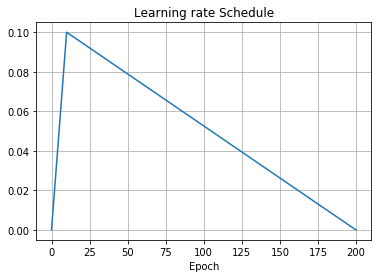

In [55]:
lr_history = []
for e in range(n_epoch):
    for _ in range(len(dataloader_train)):
        lr_history.append(scheduler.get_lr())
        scheduler.step()
        
plt.plot(np.arange(n_epoch*len(dataloader_train)) / len(dataloader_train), lr_history)
plt.grid(True)
plt.title("Learning rate Schedule")
plt.xlabel("Epoch")


In [56]:
# RE-INITIALIZE WEIGHTS (which have been destroyed during the learning-rate finder step)
model = fast_resnet(num_class=10).to(device)  
optimizer, scheduler = create_optim_schedule(model, n_epoch, max_lr=0.1)

In [57]:
train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []

total_train_time = 0

for epoch in range(n_epoch):
    train_results = train(model, dataloader_train, device, optimizer, scheduler, criterion)
    total_train_time += train_results["compute_time"]
    evaluate_test = evaluate(model, dataloader_test, criterion, device)
    evaluate_train = evaluate(model, dataloader_trainnoaugment, criterion, device)
    
    
    optim_param = get_lr(optimizer)
    
    print("Epoch: [{epoch}/{n_epoch}]  "
          "Loss: {train_loss:.2f}({test_loss:.2f})  "
          "Acc: {train_acc:.1f}%({test_acc:.1f}%)  "
          "Training: {total_train_time:.1f}sec ({compute:.1f}sec)  "
          "lr/momentum: {lr:.4f}/{momentum:.2f}".format(
        epoch=epoch+1, n_epoch=n_epoch,
        train_loss = evaluate_train["avg_loss"],
        test_loss = evaluate_test["avg_loss"],
        train_acc = 100*evaluate_train["accuracy"],
        test_acc = 100*evaluate_test["accuracy"],
        total_train_time = total_train_time,
        compute = train_results["compute_time"],
        lr = optim_param["lr"],
        momentum = optim_param["momentum"],
          ))
    
    #save statistics for later plotting
    train_loss_list.append(evaluate_train["avg_loss"])
    test_loss_list.append(evaluate_test["avg_loss"])
    train_acc_list.append(evaluate_train["accuracy"])
    test_acc_list.append(evaluate_test["accuracy"])

Epoch: [1/200]  Loss: 2.31(2.31)  Acc: 10.0%(10.0%)  Training: 1.6sec (1.6sec)  lr/momentum: 0.0102/0.90
Epoch: [2/200]  Loss: 2.34(2.34)  Acc: 10.6%(10.7%)  Training: 3.1sec (1.5sec)  lr/momentum: 0.0203/0.90
Epoch: [3/200]  Loss: 2.15(2.15)  Acc: 22.8%(22.8%)  Training: 4.6sec (1.5sec)  lr/momentum: 0.0304/0.90
Epoch: [4/200]  Loss: 1.72(1.71)  Acc: 37.6%(37.7%)  Training: 6.1sec (1.5sec)  lr/momentum: 0.0405/0.90
Epoch: [5/200]  Loss: 1.78(1.78)  Acc: 36.2%(36.2%)  Training: 7.7sec (1.6sec)  lr/momentum: 0.0506/0.90
Epoch: [6/200]  Loss: 1.99(1.99)  Acc: 32.9%(32.5%)  Training: 9.2sec (1.5sec)  lr/momentum: 0.0606/0.90
Epoch: [7/200]  Loss: 2.94(2.93)  Acc: 27.9%(28.3%)  Training: 10.7sec (1.5sec)  lr/momentum: 0.0707/0.90
Epoch: [8/200]  Loss: 2.51(2.54)  Acc: 27.1%(26.8%)  Training: 12.3sec (1.5sec)  lr/momentum: 0.0808/0.90
Epoch: [9/200]  Loss: 4.25(4.28)  Acc: 17.9%(17.6%)  Training: 13.9sec (1.7sec)  lr/momentum: 0.0909/0.90
Epoch: [10/200]  Loss: 2.13(2.13)  Acc: 33.9%(34.2%)

Epoch: [78/200]  Loss: 0.88(0.97)  Acc: 75.3%(72.8%)  Training: 120.9sec (1.6sec)  lr/momentum: 0.0642/0.90
Epoch: [79/200]  Loss: 0.85(0.95)  Acc: 76.9%(74.1%)  Training: 122.5sec (1.6sec)  lr/momentum: 0.0636/0.90
Epoch: [80/200]  Loss: 0.69(0.77)  Acc: 80.1%(77.6%)  Training: 124.1sec (1.6sec)  lr/momentum: 0.0631/0.90
Epoch: [81/200]  Loss: 0.75(0.83)  Acc: 79.0%(76.6%)  Training: 125.6sec (1.6sec)  lr/momentum: 0.0626/0.90
Epoch: [82/200]  Loss: 0.85(0.94)  Acc: 76.5%(74.2%)  Training: 127.2sec (1.6sec)  lr/momentum: 0.0621/0.90
Epoch: [83/200]  Loss: 0.81(0.89)  Acc: 77.8%(74.9%)  Training: 128.8sec (1.6sec)  lr/momentum: 0.0615/0.90
Epoch: [84/200]  Loss: 0.85(0.94)  Acc: 77.0%(74.3%)  Training: 130.3sec (1.5sec)  lr/momentum: 0.0610/0.90
Epoch: [85/200]  Loss: 1.06(1.18)  Acc: 73.3%(70.7%)  Training: 131.9sec (1.5sec)  lr/momentum: 0.0605/0.90
Epoch: [86/200]  Loss: 0.81(0.90)  Acc: 78.5%(76.1%)  Training: 133.4sec (1.5sec)  lr/momentum: 0.0599/0.90
Epoch: [87/200]  Loss: 0.71(

Epoch: [154/200]  Loss: 0.69(0.79)  Acc: 82.7%(80.3%)  Training: 239.8sec (1.6sec)  lr/momentum: 0.0242/0.90
Epoch: [155/200]  Loss: 0.71(0.80)  Acc: 82.6%(80.3%)  Training: 241.4sec (1.6sec)  lr/momentum: 0.0236/0.90
Epoch: [156/200]  Loss: 0.78(0.90)  Acc: 81.7%(79.0%)  Training: 243.0sec (1.6sec)  lr/momentum: 0.0231/0.90
Epoch: [157/200]  Loss: 0.71(0.82)  Acc: 82.6%(80.2%)  Training: 244.5sec (1.6sec)  lr/momentum: 0.0226/0.90
Epoch: [158/200]  Loss: 0.68(0.78)  Acc: 83.3%(80.9%)  Training: 246.1sec (1.5sec)  lr/momentum: 0.0221/0.90
Epoch: [159/200]  Loss: 0.66(0.76)  Acc: 83.6%(81.4%)  Training: 247.7sec (1.6sec)  lr/momentum: 0.0215/0.90
Epoch: [160/200]  Loss: 0.66(0.77)  Acc: 83.3%(80.6%)  Training: 249.2sec (1.5sec)  lr/momentum: 0.0210/0.90
Epoch: [161/200]  Loss: 0.69(0.79)  Acc: 82.7%(80.2%)  Training: 250.8sec (1.6sec)  lr/momentum: 0.0205/0.90
Epoch: [162/200]  Loss: 0.69(0.80)  Acc: 82.9%(80.5%)  Training: 252.4sec (1.5sec)  lr/momentum: 0.0199/0.90
Epoch: [163/200]  L

In [ ]:
savefile = 'MixUp30000AugmentedFastResNet'
savedir = 'saved_models/'
checkpoint = {'model_state': model.state_dict(),
              'optim_state': optimizer.state_dict(),
              'acc': evaluate_test['accuracy']}
torch.save(checkpoint, savedir + savefile + '.model')

In [58]:
trainset = reformed_CIFAR10(base, train=True, transform=train_augment, download=False)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=500,
                                               shuffle=True, num_workers=5)
testset = reformed_CIFAR10(base, train=False, transform=test_augment, download=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=500,
                                               shuffle=True, num_workers=5)

nbutils.encode_dump(model.encoder, 'Fast_resnet5000MixupCutout.pt', trainloader, device, False)
nbutils.encode_dump(model.encoder, 'Fast_resnet5000MixupCutout_test', testloader, device, True)

dumping 10000 size data at Fast_resnet5000MixupCutout.pt1
dumping 10000 size data at Fast_resnet5000MixupCutout.pt2
dumping 10000 size data at Fast_resnet5000MixupCutout.pt3
dumping 10000 size data at Fast_resnet5000MixupCutout.pt4
dumping 10000 size data at Fast_resnet5000MixupCutout.pt5
dumping 10000 size data at Fast_resnet5000MixupCutout_test1
